In [1]:
import warnings
warnings.simplefilter('ignore')

import tensorflow as tf
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg.eigen.arpack import eigsh
import scipy.sparse as sp
import pandas as pd
import pickle
from datetime import timedelta
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
import datetime

from utils import normalize_adj, StandardScaler
from gcn import gcn, gcnn_ddgf

In [2]:
tf.__version__

'1.14.0'

### Import Data

In [3]:
file_Name = "./data/NYCBikeHourly272.pickle"
fileObject = open(file_Name,'rb') 
hourly_bike = pickle.load(fileObject) 
hourly_bike = pd.DataFrame(hourly_bike)

### Split Data into Training, Validation and Testing

In [4]:
node_num = 272 # node number 
feature_in = 24 # number of features at each node, e.g., bike sharing demand from past 24 hours
horizon = 1 # the length to predict, e.g., predict the future one hour bike sharing demand

X_whole = []
Y_whole = []

x_offsets = np.sort(
    np.concatenate((np.arange(-feature_in+1, 1, 1),))
)

y_offsets = np.sort(np.arange(1, 1+ horizon, 1))

min_t = abs(min(x_offsets))
max_t = abs(hourly_bike.shape[0] - abs(max(y_offsets)))  # Exclusive
for t in range(min_t, max_t):
    x_t = hourly_bike.iloc[t + x_offsets, 0:node_num].values.flatten('F')
    y_t = hourly_bike.iloc[t + y_offsets, 0:node_num].values.flatten('F')
    X_whole.append(x_t)
    Y_whole.append(y_t)

X_whole = np.stack(X_whole, axis=0)
Y_whole = np.stack(Y_whole, axis=0)

X_whole = np.reshape(X_whole, [X_whole.shape[0], node_num, feature_in])


In [5]:
num_samples = X_whole.shape[0]
num_train = 20000 
num_val = 2000
num_test = 2000

X_training = X_whole[:num_train, :]
Y_training = Y_whole[:num_train, :]

# shuffle the training dataset
perm = np.arange(X_training.shape[0])
np.random.shuffle(perm)
X_training = X_training[perm]
Y_training = Y_training[perm]

X_val = X_whole[num_train:num_train+num_val, :]
Y_val = Y_whole[num_train:num_train+num_val, :]

X_test = X_whole[num_train+num_val:num_train+num_val+num_test, :]
Y_test = Y_whole[num_train+num_val:num_train+num_val+num_test, :]


scaler = StandardScaler(mean=X_training.mean(), std=X_training.std())

X_training = scaler.transform(X_training)
Y_training = scaler.transform(Y_training)

X_val = scaler.transform(X_val)
Y_val = scaler.transform(Y_val)

X_test = scaler.transform(X_test)
Y_test = scaler.transform(Y_test)

### Hyperparameters

In [6]:
learning_rate = 0.01 # learning rate
decay = 0.9
batchsize = 100 # batch size 

hidden_num_layer = [10, 10, 20] # determine the number of hidden layers and the vector length at each node of each hidden layer
reg_weight = [0, 0, 0] # regularization weights for adjacency matrices L1 loss

keep = 1 # drop out probability

early_stop_th = 200 # early stopping threshold, if validation RMSE not dropping in continuous 20 steps, break
training_epochs = 500 # total training epochs

### Training

In [7]:
start_time = datetime.datetime.now()

val_error, predic_res, test_Y, test_error, bestWeightA = gcnn_ddgf(hidden_num_layer, reg_weight, node_num, feature_in, horizon, 
                                                                   learning_rate, decay, batchsize, keep, early_stop_th, training_epochs, 
                                                                   X_training, Y_training, X_val, Y_val, X_test, Y_test, scaler, 'RMSE')
end_time = datetime.datetime.now()

print('Total training time: ', end_time-start_time)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch: 0001 Training RMSE = 3.936679145
Validation RMSE: 3.6874359
Epoch: 0002 Training RMSE = 3.422823601
Validation RMSE: 3.623373
Epoch: 0003 Training RMSE = 3.195017954
Validation RMSE: 3.508453
Epoch: 0004 Training RMSE = 3.100379407
Validation RMSE: 3.5189042
Epoch: 0005 Training RMSE = 3.056049792
Validation RMSE: 3.4705627
Epoch: 0006 Training RMSE = 3.027264036
Validation RMSE: 3.4443092
Epoch: 0007 Training RMSE = 3.005823829
Validation RMSE: 3.4251976
Epoch: 0008 Training RMSE = 2.987815338
Validation RMSE: 3.410573
Epoch: 0009 Training RMSE = 2.973032398
Validation RMSE: 3.3961828
Epoch: 0010 Training RMSE = 2.958385454
Validation RMSE: 3.3808875
Epoch: 0011 Training RMSE = 2.944998465
Validation RMSE: 3.3633416
Epoch: 0012 Training RMSE = 2.932787576
Validation RMSE: 3.3350585
Epoch: 0013 Training RMSE = 2.920960150
Validation RMSE: 3.3147326
Epoch: 0014 Training RMSE = 2.9

In [8]:
np.savetxt("prediction.csv", predic_res, delimiter = ',')
np.savetxt("prediction_Y.csv", test_Y, delimiter = ',')

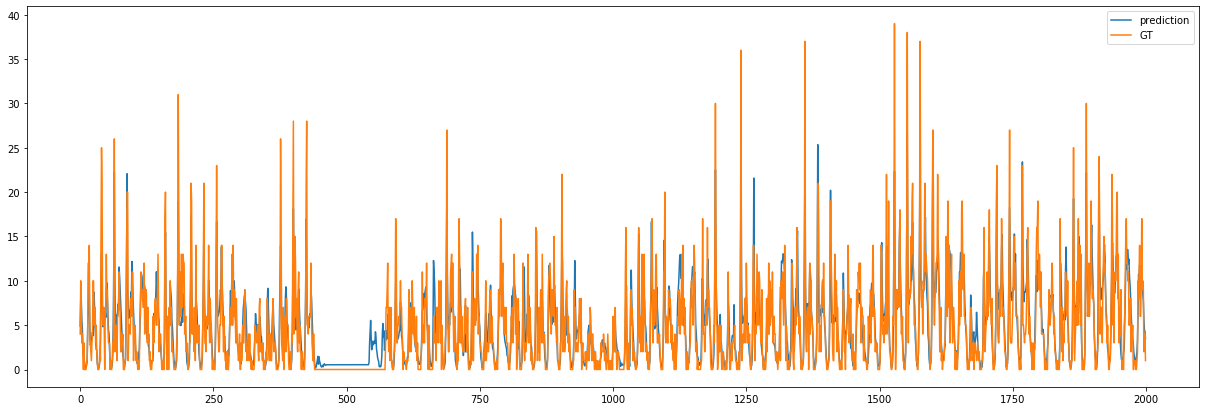

In [21]:
idx = 0 # Node(Station) index
plt.figure(figsize=(21, 7))
plt.plot(predic_res[:, idx], label='prediction')
plt.plot(test_Y[:, idx], label='GT')

# plt.xlim(24*5, 24*15)
# plt.ylim(-2,35)
plt.legend()
plt.show()